In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import time

In [60]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

In [38]:
class testLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False, num_layers=1):
        super(testLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=False, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, input):
        output = input
        rnn_output, _ = self.rnn(output)
        output = self.fc(rnn_output)
        return output

In [194]:
from sklearn.preprocessing import MinMaxScaler

In [223]:
lstm

testLSTM(
  (rnn): LSTM(1, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [224]:
df = pd.read_csv('data/2012.csv', encoding='euc-kr')
for y in range(2013, 2023):
    new_df = pd.read_csv('data/{}.csv'.format(y), encoding='euc-kr')
    df = pd.concat([df, new_df])
df = df.reset_index(drop=True)


In [238]:
def is_cont(df):
    point = np.array(df['지점'])
    location = np.array(df['지점명'])
    date = np.array(df['일시'])
    snow = np.array(df['적설(cm)']) * 10
    year = []
    month = []
    day = []
    hour = []
    strp = []
    mk = []
    continuous_1_hour = []
    continuous_3_hours = []
    continuous_6_hours = []

    for n, t in enumerate(date):
        t = time.strptime(t, '%Y-%m-%d %H:%M')
        strp.append(t)
        mk.append(time.mktime(t))
        year.append(t.tm_year)
        month.append(t.tm_mon)
        day.append(t.tm_mday)
        hour.append(t.tm_hour)

    # for n, k in enumerate(mk):
    #     is_1_hour = (k + 3600.0 in mk)
    #     is_3_hours = (k + 10800.0 in mk)
    #     is_6_hours = (k + 21600.0 in mk)
    #     continuous_1_hour.append(is_1_hour)
    #     continuous_3_hours.append(is_3_hours)
    #     continuous_6_hours.append(is_6_hours)
    dic = {'point': point, 'location': location, 'snow': snow, 'year': year, 'month': month, 'day': day, 'hour': hour}
    df2 = pd.DataFrame(dic)
    return df2

In [347]:
print(df.groupby('지점명').count()['지점'].to_string())

지점명
강릉           475
강진군          717
강화           713
거제            27
거창          1730
경주시          371
고산           330
고창          3863
고창군         3115
고흥            44
광양시           91
광주          2609
구미           369
군산          2520
금산           539
김해시           44
남원          1425
남해             9
대관령        10201
대구           674
대구(기)         43
대전          2822
동두천         2302
동해          1024
목포          2497
문경           309
밀양           156
백령도         4793
보령          3017
보성군          214
보은           662
봉화           479
부산            19
부안           906
부여           508
북강릉         4702
북창원          223
북춘천         2069
산청           223
상주           848
서귀포          486
서산          3467
서울          3868
성산          1051
세종           645
속초          3009
수원          3199
순창군         2020
순천          1265
안동          1843
양산시           42
양평           636
여수            59
영광군         1807
영덕            26
영월          1553
영주           299
영천            56
완도        

In [441]:
df_90 = df.fillna(0)

df_90 = df_90[df_90['지점명']=='울릉도']
df_90 = df_90[df_90['적설(cm)']>0]
df2_90 = is_cont(df_90)

In [442]:
df2_90_train = df2_90[df2_90['year'] < 2018]
df2_90_test = df2_90[df2_90['year'] >= 2018]
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(np.array(df2_90_train['snow']).reshape(-1, 1))

In [443]:
df2_90_test

,point,location,snow,year,month,day,hour
8094,115,울릉도,1.0,2018,1,3,1
8095,115,울릉도,11.0,2018,1,3,2
8096,115,울릉도,11.0,2018,1,3,3
8097,115,울릉도,11.0,2018,1,3,4
8098,115,울릉도,13.0,2018,1,3,5
...,...,...,...,...,...,...,...
13083,115,울릉도,14.0,2022,2,26,13
13084,115,울릉도,11.0,2022,2,26,14
13085,115,울릉도,6.0,2022,2,26,15
13086,115,울릉도,3.0,2022,2,26,16


In [444]:
hours = 6

In [445]:
df2_90_train['snow'][:-hours]

0       39.0
1       39.0
2       39.0
3       39.0
4       39.0
        ... 
8083    15.0
8084    15.0
8085    15.0
8086    15.0
8087    14.0
Name: snow, Length: 8088, dtype: float64

In [446]:
df2_90_train['snow'][hours:]

6       39.0
7       38.0
8       38.0
9       38.0
10      37.0
        ... 
8089    10.0
8090     7.0
8091     5.0
8092     2.0
8093     1.0
Name: snow, Length: 8088, dtype: float64

In [474]:
input_data = torch.tensor(scaler.transform(np.array(df2_90_train['snow'][:-hours]).reshape(-1, 1)), dtype=torch.float).reshape(-1, 1, 1).to(device)
target_data = torch.tensor(scaler.transform(np.array(df2_90_train['snow'][hours:]).reshape(-1, 1)), dtype=torch.float).reshape(-1, 1, 1).to(device)

In [448]:
class CustomDataset(Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [449]:
lstm = testLSTM(1, 10, 0.0, False, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
train_dataset = CustomDataset(input_data, target_data)
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [450]:
for epoch in range(2000):
    loss_epoch = []
    

        
    output = lstm(input_data)
    loss = criterion(output, target_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += [loss.item()]
    
    if (epoch + 1) % 100 == 0:
            print("Epoch {} | Loss {:.4f}".format(epoch+1, np.mean(loss_epoch)))

Epoch 100 | Loss 0.0016
Epoch 200 | Loss 0.0013
Epoch 300 | Loss 0.0012
Epoch 400 | Loss 0.0011
Epoch 500 | Loss 0.0010
Epoch 600 | Loss 0.0012
Epoch 700 | Loss 0.0009
Epoch 800 | Loss 0.0009
Epoch 900 | Loss 0.0009
Epoch 1000 | Loss 0.0009
Epoch 1100 | Loss 0.0009
Epoch 1200 | Loss 0.0009
Epoch 1300 | Loss 0.0009
Epoch 1400 | Loss 0.0008
Epoch 1500 | Loss 0.0008
Epoch 1600 | Loss 0.0008
Epoch 1700 | Loss 0.0008
Epoch 1800 | Loss 0.0008
Epoch 1900 | Loss 0.0008
Epoch 2000 | Loss 0.0008


In [451]:
input_data_test = torch.tensor(scaler.transform(np.array(df2_90_test['snow'][:-hours]).reshape(-1, 1)), dtype=torch.float).reshape(-1, 1, 1).to(device)
target_data_test = torch.tensor(scaler.transform(np.array(df2_90_test['snow'][hours:]).reshape(-1, 1)), dtype=torch.float).reshape(-1, 1, 1).to(device)

In [458]:
output_test = scaler.inverse_transform(lstm(input_data_test).detach().cpu().numpy().reshape(-1, 1))
output_test = np.where(output_test < 0, 0, output_test)
target_test = np.array(df2_90_test['snow'][hours:])

In [459]:
import matplotlib.pyplot as plt

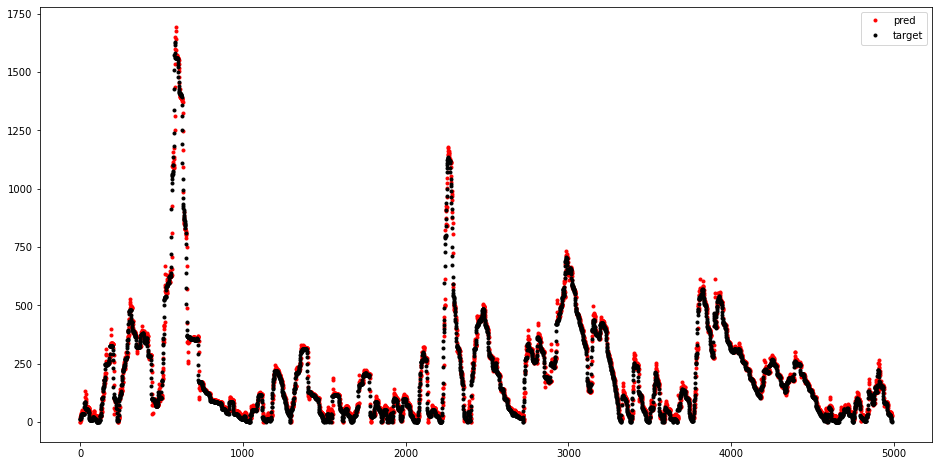

In [460]:
plt.figure(figsize=(16, 8))
plt.plot(output_test, 'r.', label='pred')
plt.plot(target_test, 'k.', label='target')
plt.legend()

In [461]:
np.sqrt(np.sum((output_test.flatten() - target_test) ** 2) / np.sum(output_test.flatten() ** 2))

0.12490212100213101

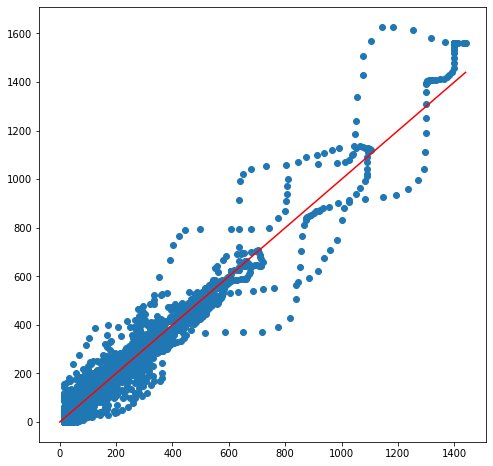

In [488]:
plt.figure(figsize=(8, 8))
plt.scatter(output_test, target_test)
plt.plot([0, np.max(output_test)], [0, np.max(output_test)], 'r-')

Bayesian LSTM

In [463]:
from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

In [468]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [478]:
net = NN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [479]:
for epoch in range(2000):
    loss_epoch = []
    output = net(input_data)
    loss = criterion(output, target_data.reshape(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += [loss.item()]
    
    if (epoch + 1) % 100 == 0:
            print("Epoch {} | Loss {:.4f}".format(epoch+1, np.mean(loss_epoch)))

Epoch 100 | Loss 0.0012
Epoch 200 | Loss 0.0014
Epoch 300 | Loss 0.0015
Epoch 400 | Loss 0.0012
Epoch 500 | Loss 0.0021
Epoch 600 | Loss 0.0012
Epoch 700 | Loss 0.0012
Epoch 800 | Loss 0.0012
Epoch 900 | Loss 0.0012
Epoch 1000 | Loss 0.0012
Epoch 1100 | Loss 0.0012
Epoch 1200 | Loss 0.0012
Epoch 1300 | Loss 0.0014
Epoch 1400 | Loss 0.0012
Epoch 1500 | Loss 0.0012
Epoch 1600 | Loss 0.0012
Epoch 1700 | Loss 0.0012
Epoch 1800 | Loss 0.0014
Epoch 1900 | Loss 0.0012
Epoch 2000 | Loss 0.0012


In [513]:
def get_confidence_intervals(preds_test, ci_multiplier):
    pred_mean = np.mean(preds_test, axis=0)
    pred_std = np.std(preds_test, axis=0)
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    return pred_mean, upper_bound, lower_bound

In [532]:
input_data_test = torch.tensor(scaler.transform(np.array(df2_90_test['snow'][:-hours]).reshape(-1, 1)), dtype=torch.float).reshape(-1, 1, 1).to(device)
target_data_test = torch.tensor(scaler.transform(np.array(df2_90_test['snow'][hours:]).reshape(-1, 1)), dtype=torch.float).reshape(-1, 1, 1).to(device)
output_test = np.array([scaler.inverse_transform(net(input_data_test).detach().cpu().numpy().reshape(-1, 1)) for i in range(5)])
output_test = np.where(output_test < 0, 0, output_test)
print(output_test.shape)
target_test = np.array(df2_90_test['snow'][hours:])
pred_mean, upper_bound, lower_bound = get_confidence_intervals(output_test, 1.96)

(5, 4988, 1)


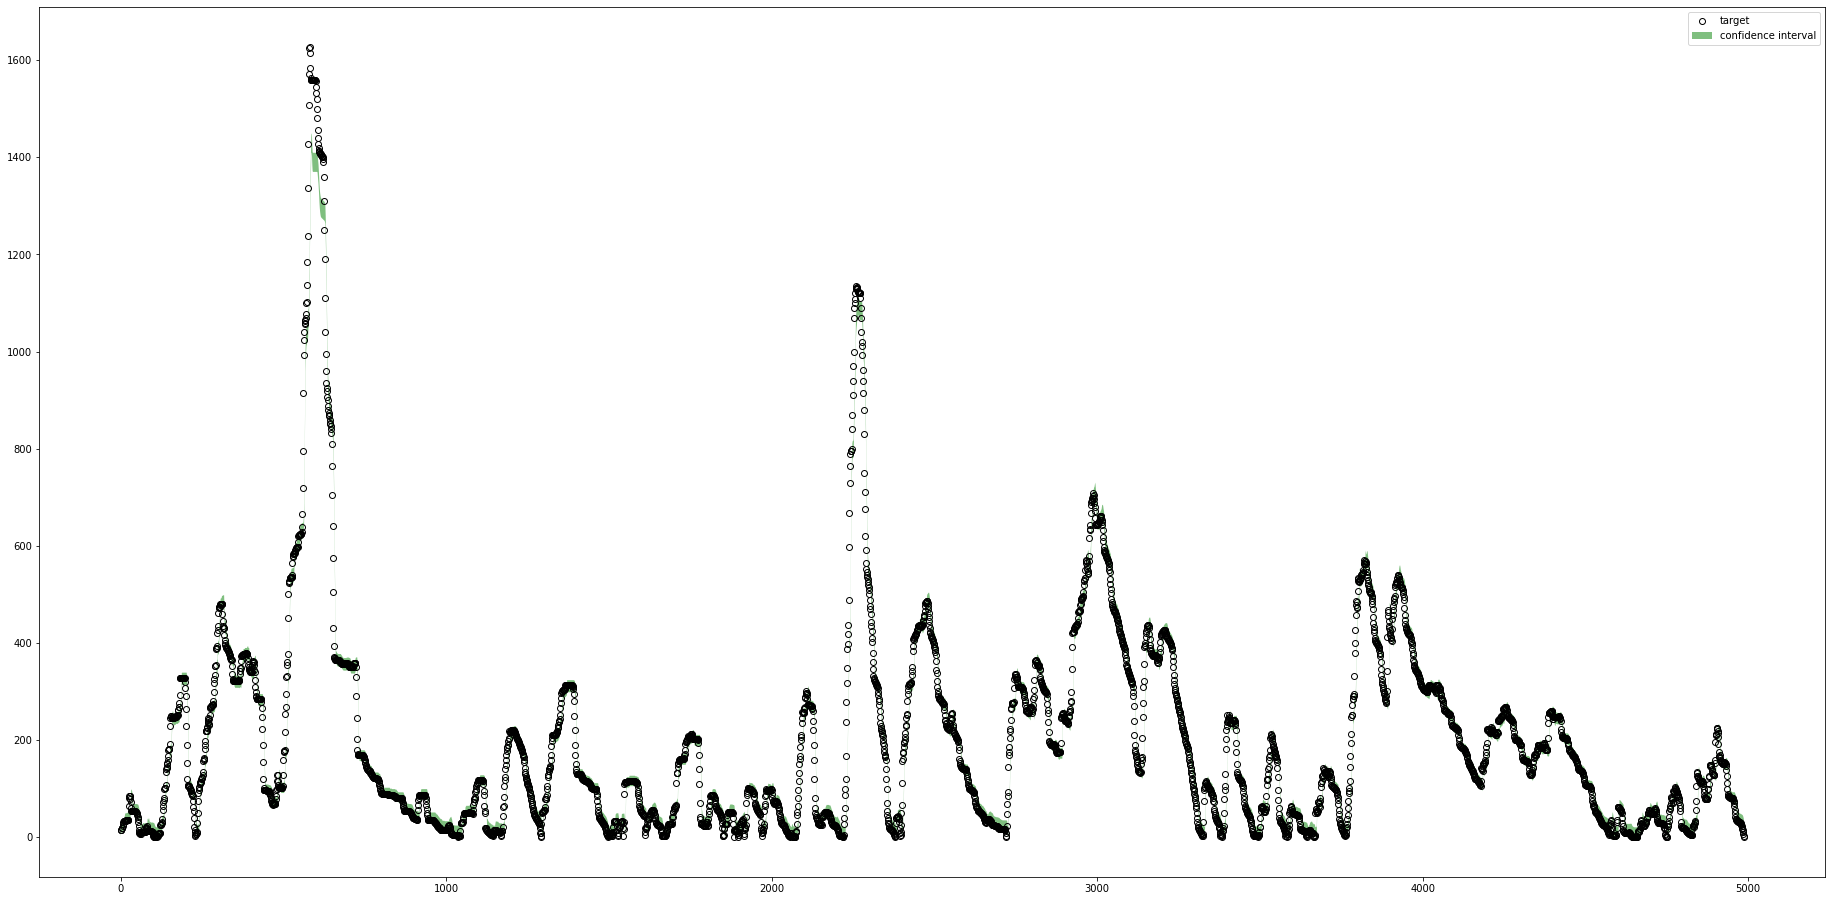

In [539]:
plt.figure(figsize=(32, 16))
x_idx = np.arange(len(upper_bound))
# plt.plot(pred_mean, 'r-', linewidth=5, label='mean pred')
plt.plot(target_test, fillstyle='none', marker='o', color='k', label='target', linestyle='none')
plt.fill_between(x=x_idx, y1=upper_bound.flatten(), y2=lower_bound.flatten(), facecolor='green', label='confidence interval', alpha=0.5)
plt.legend()

In [540]:
np.sqrt(np.sum((pred_mean.flatten() - target_test) ** 2) / np.sum(pred_mean.flatten() ** 2))

0.16067174524077954

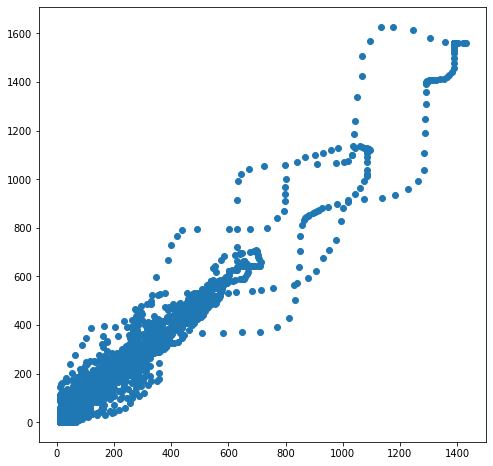

In [542]:
plt.figure(figsize=(8, 8))

plt.scatter(pred_mean, target_test)